In [1]:
import pandas as pd
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import SGDRegressor, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from math import *
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
#load the tsv files of the features and respective responses
df=pd.read_csv('MP_Data.tsv', sep='\t', index_col=False)
tt_df=df.rename(columns={'x':'test_train'})
#tt_df

In [3]:
x_df=pd.read_csv('MP_Descriptors.tsv', sep='\t', index_col=False)
#x_df

In [4]:
y_df_init=pd.read_csv('MP_Outcome.tsv', sep='\t')
y_df=y_df_init.rename(columns={'x':'outcome'})
y_df.head()

,outcome
0,14.0
1,20.5
2,27.5
3,30.5
4,31.0


In [5]:
#sort the data according to exteranl and principal datasets sets
x_dataset_init_df=x_df[tt_df['test_train']=='Train']
x_external_init_df=x_df[tt_df['test_train']=='Test']

y_dataset_init_df=y_df[tt_df['test_train']=='Train']
y_external_init_df=y_df[tt_df['test_train']=='Test']

In [6]:
x_dataset_init_df.shape, y_dataset_init_df.shape, x_external_init_df.shape, y_external_init_df.shape

((4126, 202), (4126, 1), (275, 202), (275, 1))

In [7]:
x_dataset_init_df.head()

,diameter,petitjean,petitjeanSC,radius,VDistEq,VDistMa,weinerPath,weinerPol,a_aro,a_count,...,FASA_P,FCASA.,FCASA..1,VSA,dens,glob,std_dim1,std_dim2,std_dim3,vol
0,5,0.400000,0.666667,3,2.037476,6.011166,82,9,6,15,...,0.129128,0.326050,0.224950,138.13699,0.958985,0.031032,1.853123,1.382682,0.326444,123.18750
1,9,0.444444,0.800000,5,2.954872,8.805204,1046,40,11,31,...,0.059026,0.847237,1.136764,296.30197,1.296254,0.258447,2.394159,1.966377,1.217135,262.82812
2,10,0.500000,1.000000,5,3.083532,8.211762,742,24,12,35,...,0.046707,0.817581,0.464419,296.54431,0.946322,0.162139,3.164745,1.552043,1.274330,266.62500
3,7,0.428571,0.750000,4,2.616827,7.313269,288,20,10,20,...,0.044688,0.417896,0.574827,187.43799,1.195242,0.018573,2.524826,1.446899,0.344087,164.95312
4,7,0.428571,0.750000,4,2.609669,6.833154,203,13,6,22,...,0.103925,0.595412,0.267278,193.42802,0.978233,0.088156,2.550456,1.430062,0.757260,165.79688


In [8]:
x_dataset_df=np.array(x_dataset_init_df)
x_external_df=np.array(x_external_init_df)
x_dataset_df.shape, x_external_df.shape

((4126, 202), (275, 202))

In [9]:
y_dataset_df=np.array(y_dataset_init_df)
y_external_df=np.array(y_external_init_df)

In [10]:
#normalize the output
y_scaler=StandardScaler()
y_scaler.fit(y_dataset_df)
y_train_norm=y_scaler.transform(y_dataset_df)
y_external_norm=y_scaler.transform(y_external_df)

In [11]:
#normalize the inputs
x_scaler=StandardScaler()
x_scaler.fit(x_dataset_df)
x_train_pca=x_scaler.transform(x_dataset_df)
x_external_pca=x_scaler.transform(x_external_df)

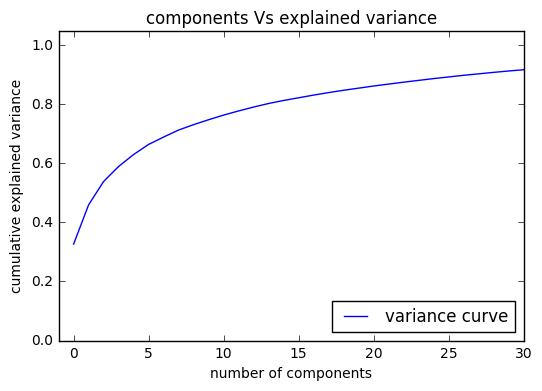

In [12]:
#feature selection
pca=PCA().fit(x_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='variance curve')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.05])
plt.xlim([-1, 30])
plt.title('components Vs explained variance')
plt.show()

In [13]:
pca=PCA(n_components=30)#from the literature
pca.fit(x_train_pca)
x_train_norm=pca.transform(x_train_pca)
x_external_norm=pca.transform(x_external_pca)

x_train_norm.shape, x_external_norm.shape

((4126, 30), (275, 30))

In [14]:
pc_1=x_train_norm[:, 1]
pc_2=x_train_norm[:, 2]
pc_ex_1 = x_external_norm[:,1]
pc_ex_2 = x_external_norm[:,2]

C:\Users\saiva\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


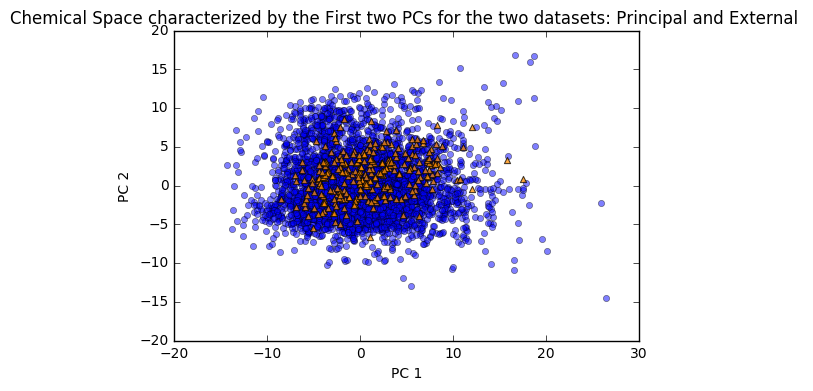

In [15]:

for i in range(0, 4126):
    plt.scatter(pc_1[i], pc_2[i], c='b', alpha=0.5, marker='o', lw=0.5)
plt.hold(True)
for i in range(0, 275):    
    plt.scatter(pc_ex_1[i], pc_ex_2[i], c='darkorange', alpha=0.75, marker = '^', lw=0.75)

    #plt.scatter(x_external_df[], y_external_df)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Chemical Space characterized by the First two PCs for the two datasets: Principal and External ')
plt.legend(loc='lower right')
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
x_training_set, x_test_set, y_training_set, y_test_set = train_test_split(x_train_norm, y_train_norm, test_size=0.2)
x_training_set.shape, x_test_set.shape, y_training_set.shape, y_test_set.shape

((3300, 30), (826, 30), (3300, 1), (826, 1))

In [58]:
#model building-linear regression
regr=linear_model.LinearRegression()
regr.fit(x_training_set, y_training_set)
y_predict_linear=regr.predict(x_test_set)
#normalize the y_predict
#y_predict_norm=y_scaler.fit_transform(y_predict)
#evaluate the model
#r2_linear=r2_score(y_predict_norm, y_test_norm)
r2_linear=r2_score(y_test_set, y_predict_linear)
print('r2:',r2_linear)
mse_linear=mean_squared_error(y_test_set, y_predict_linear)
print('mse :',mse_linear)
rmse_linear=sqrt(mse_linear)
print('rmse:', rmse_linear)
mae_linear=mean_absolute_error(y_test_set, y_predict_linear)
print('mae:', mae_linear)

r2: 0.439603477173
mse : 0.559406524385
rmse: 0.747934839665425
mae: 0.587428213509


In [18]:
#y_predict_true_linear=y_scaler.inverse_transform(y_predict_linear)
#mse in the true space
#r2_linear=r2_score(y_test_set, y_predict_true_linear)
#print('r2 for linear in true space:', r2_linear)
#mse_linear=mean_squared_error(y_test_set, y_predict_true_linear)
#print('mse for linear in true space:', mse_linear)
#rmse_linear=sqrt(mse_linear)
#print('rmse for linear in true space:', rmse_linear)
#mae_linear=mean_absolute_error(y_test_set, y_predict_true_linear)
#print('mae for linear in true space:', mae_linear)

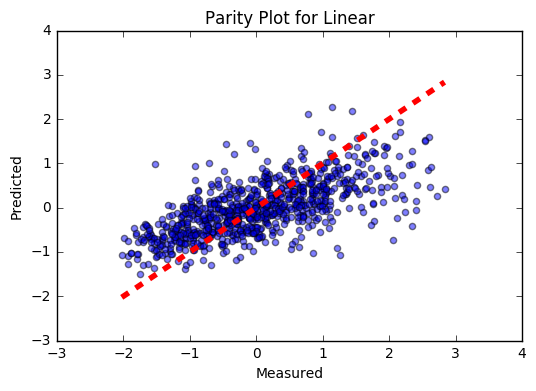

In [19]:
#predicted = cross_val_predict(regr, x_test, y_test, cv=10)
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_linear, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()],'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Linear')
plt.show()

In [20]:
regr.score(x_training_set, y_training_set)

0.43067282761866188

In [21]:
#Lasso
regr_lasso=linear_model.Lasso(alpha=0.01)
regr_lasso.fit(x_training_set, y_training_set)
y_predict_lasso=regr_lasso.predict(x_test_set)
#scale back to true space
#y_predict_lasso_true=y_scaler.inverse_transform(y_predict_lasso)
#evaluate
mse_lasso=mean_squared_error(y_test_set, y_predict_lasso)
rmse_lasso=sqrt(mse_lasso)
mae_lasso=mean_absolute_error(y_test_set, y_predict_lasso)
r2_lasso=r2_score(y_test_set, y_predict_lasso)
print('r2 for lasso:',r2_lasso)
print('rmse for lasso', rmse_lasso)
print('mae for lasso', mae_lasso)

r2 for lasso: 0.437976578378
rmse for lasso 0.7490197254377593
mae for lasso 0.590791392781


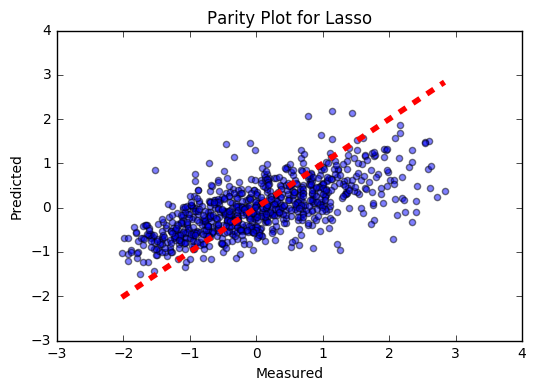

In [22]:
from sklearn.model_selection import cross_val_predict
#predicted = cross_val_predict(regr, x_test, y_test, cv=10)
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_lasso, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Lasso')
plt.show()

In [23]:
regr_lasso.score(x_training_set, y_training_set)

0.42925304379388729

In [24]:
#LassoCV
model_CV=LassoCV(cv=20).fit(x_training_set, y_training_set)
y_predict_CV = model_CV.predict(x_test_set)
#scale back to true space
#y_predict_CV_true=y_scaler.inverse_transform(y_predict_CV)
#evaluate
mse_lassoCV=mean_squared_error(y_test_set, y_predict_CV)
rmse_lassoCV=sqrt(mse_lassoCV)
r2_lassoCV=r2_score(y_test_set, y_predict_CV)
mae_lassoCV=mean_absolute_error(y_test_set, y_predict_CV)
print('r2 for lassoCV:',r2_lassoCV)
print('rmse for lassoCV',rmse_lassoCV )
print('mae for lassoCV', mae_lassoCV)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 for lassoCV: 0.438714716118
rmse for lassoCV 0.7485276984534974
mae for lassoCV 0.589643887279


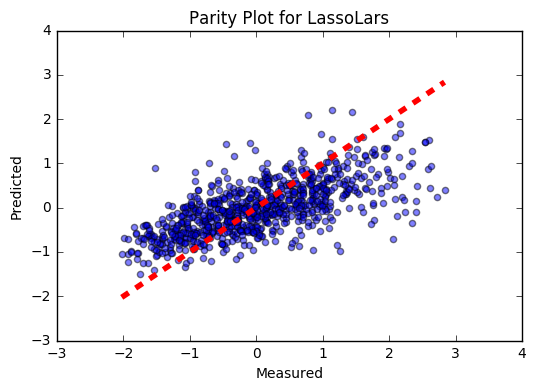

In [25]:
#from sklearn.model_selection import cross_val_predict
#predicted = cross_val_predict(regr, x_test, y_test, cv=10)
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_CV, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for LassoLars')
plt.show()

In [26]:
#LassoLarsCV
model_larsCV=LassoLarsCV(cv=20).fit(x_training_set, y_training_set)
y_predict_larsCV=model_larsCV.predict(x_test_set)
#scale back to true space
#y_predict_larsCV_true=y_scaler.inverse_transform(y_predict_larsCV)
#evaluate
r2_larsCV=r2_score(y_test_set, y_predict_larsCV)
mse_larsCV=mean_squared_error(y_test_set, y_predict_larsCV)
rmse_larsCV=sqrt(mse_larsCV)
mae_larsCV=mean_absolute_error(y_test_set, y_predict_larsCV)
print('rmse for lassCV:', rmse_larsCV)
print('r2 for lasso larsCV:',r2_larsCV)
print('mae for larsCV:', mae_larsCV)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


rmse for lassCV: 0.7489769244369805
r2 for lasso larsCV: 0.438040807602
mae for larsCV: 0.590492748353


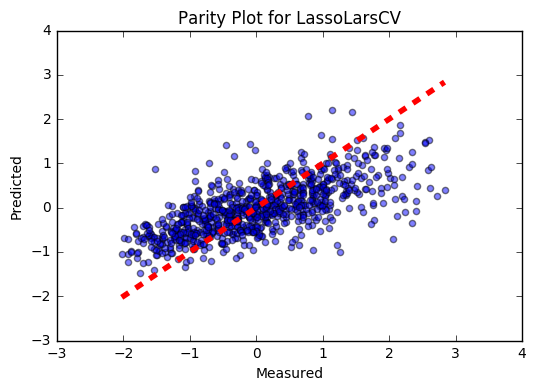

In [27]:
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_larsCV, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for LassoLarsCV')
plt.show()

In [28]:
#Bayesian Ridge
regr_b=linear_model.BayesianRidge()
model_b=regr_b.fit(x_training_set, y_training_set)
y_predict_b=model_b.predict(x_test_set)
#scale back to original space
#y_predict_b_true=y_scaler.inverse_transform(y_predict_b)
#evaluate
mse_b=mean_squared_error(y_test_set, y_predict_b)
rmse_b=sqrt(mse_b)
mae_b=mean_absolute_error(y_test_set, y_predict_b)
r2_b=r2_score(y_test_set, y_predict_b)
print('r2 for bayesian in true space:',r2_b)
print('rmse for bayesian in true space:', rmse_b)
print('mae for bayesian in true space:', mae_b)

r2 for bayesian in true space: 0.438596484531
rmse for bayesian in true space: 0.7486065308763943
mae for bayesian in true space: 0.588773051154


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


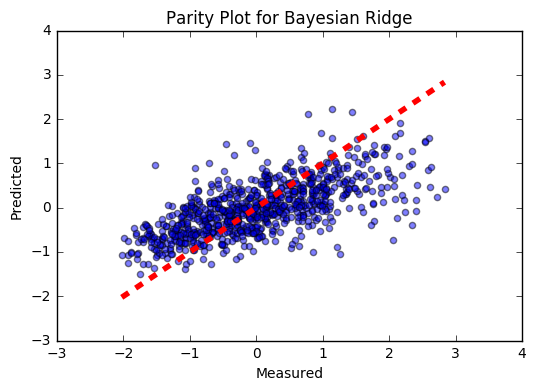

In [29]:
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_b, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Bayesian Ridge')
plt.show()

In [30]:
#stochastic gradient descent
regr_sgd=SGDRegressor(loss='squared_loss', penalty=None, alpha=0.001, epsilon=0.0001)
model_sgd=regr_sgd.fit(x_training_set, y_training_set)
y_predict_sgd=model_sgd.predict(x_test_set)
#scale back to original space
#y_predict_sgd_true=y_scaler.inverse_transform(y_predict_sgd)
#evaluate
mse_sgd=mean_squared_error(y_test_set, y_predict_sgd)
rmse_sgd=sqrt(mse_sgd)
mae_sgd=mean_absolute_error(y_test_set, y_predict_sgd)
r2_sgd=r2_score(y_test_set, y_predict_sgd)
print('r2 for sgd in true space:',r2_sgd)
print('rmse for sgd in true space:', rmse_sgd)
print('mae for sgd in true space:', mae_sgd)

r2 for sgd in true space: 0.420449822953
rmse for sgd in true space: 0.7606091911708458
mae for sgd in true space: 0.591944960766


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


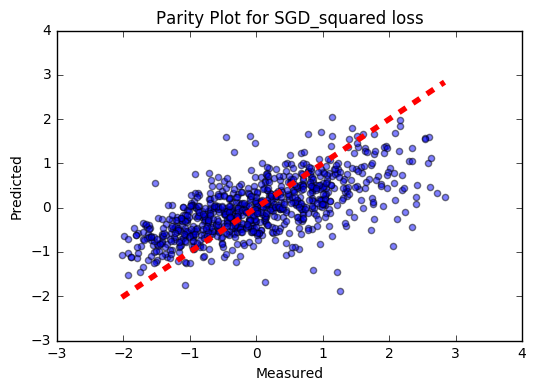

In [31]:
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_sgd, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for SGD_squared loss')
plt.show()

In [32]:
regr_sgd2=linear_model.SGDRegressor(loss='huber', penalty=None)
model_sgd2=regr_sgd2.fit(x_training_set, y_training_set)
y_predict_sgd2=model_sgd2.predict(x_test_set)
#scale back to original space
#y_predict_sgd2_true=y_scaler.inverse_transform(y_predict_sgd2)
#evaluate
mse_sgd2=mean_squared_error(y_test_set, y_predict_sgd2)
rmse_sgd2=sqrt(mse_sgd2)
mae_sgd2=mean_absolute_error(y_test_set, y_predict_sgd2)
r2_sgd2=r2_score(y_test_set, y_predict_sgd2)
print('r2 for sgd2 in true space:',r2_sgd2)
print('rmse for sgd2 in true space:', rmse_sgd2)
print('mae for sgd2 in true space:', mae_sgd2)

r2 for sgd2 in true space: 0.431431892943
rmse for sgd2 in true space: 0.7533682185138324
mae for sgd2 in true space: 0.583032113803


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


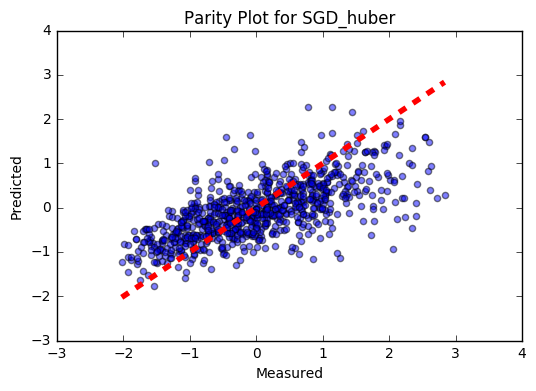

In [33]:
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_sgd2, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for SGD_huber')
plt.show()

In [34]:
regr_sgd3=linear_model.SGDRegressor(loss='epsilon_insensitive', penalty='none', alpha=0.0001)
model_sgd3=regr_sgd3.fit(x_training_set, y_training_set)
y_predict_sgd3=model_sgd3.predict(x_test_set)
#scale back to original space
#y_predict_sgd3_true=y_scaler.inverse_transform(y_predict_sgd3)
#evaluate
mse_sgd3=mean_squared_error(y_test_set, y_predict_sgd3)
rmse_sgd3=sqrt(mse_sgd3)
mae_sgd3=mean_absolute_error(y_test_set, y_predict_sgd3)
r2_sgd3=r2_score(y_test_set, y_predict_sgd3)
print('r2 for sgd3 in true space:',r2_sgd3)
print('rmse for sgd3 in true space:', rmse_sgd3)
print('mae for sgd3 in true space:', mae_sgd3)

r2 for sgd3 in true space: 0.376336770717
rmse for sgd3 in true space: 0.7890256419523566
mae for sgd3 in true space: 0.60812342238


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


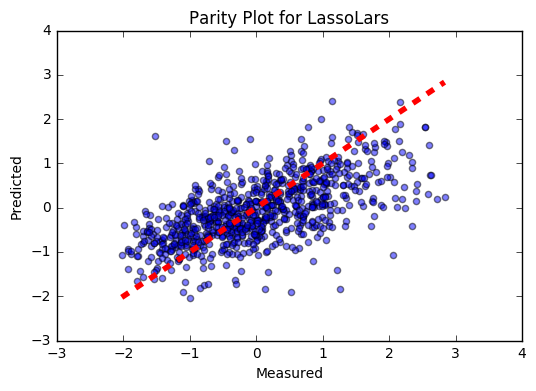

In [35]:
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_sgd3, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for LassoLars')
plt.show()

In [36]:
#using tree
regr_tree=tree.DecisionTreeRegressor()
model_tree=regr_tree.fit(x_training_set, y_training_set)
y_predict_tree=model_tree.predict(x_test_set)
#scale back to original space
#y_predict_tree_true=y_scaler.inverse_transform(y_predict_tree)
#evaluate
mse_tree=mean_squared_error(y_test_set, y_predict_tree)
rmse_tree=sqrt(mse_tree)
mae_tree=mean_absolute_error(y_test_set, y_predict_tree)
r2_tree=r2_score(y_test_set, y_predict_tree)
print('r2 for tree in true space:',r2_tree)
print('rmse for tree in true space:', rmse_tree)
print('mae for tree in true space:', mae_tree)

r2 for tree in true space: -0.0670648534765
rmse for tree in true space: 1.0320754686571074
mae for tree in true space: 0.800682085212


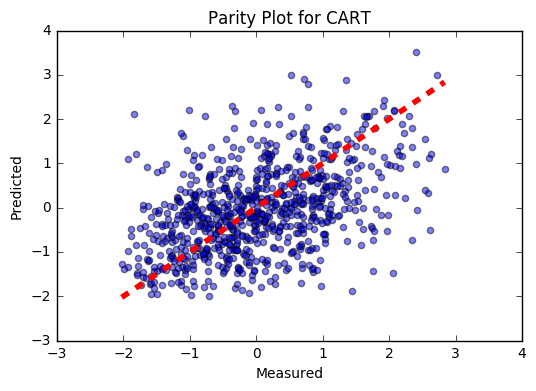

In [37]:
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_tree, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for CART')
plt.show()

In [38]:
regr_ridge=linear_model.Ridge(alpha=0.75)
model_ridge=regr_ridge.fit(x_training_set, y_training_set)
y_predict_ridge=model_ridge.predict(x_test_set)
#scale back to original space
#y_predict_ridge_true=y_scaler.inverse_transform(y_predict_ridge)
#evaluate
mse_ridge=mean_squared_error(y_test_set, y_predict_ridge)
rmse_ridge=sqrt(mse_ridge)
mae_ridge=mean_absolute_error(y_test_set, y_predict_ridge)
r2_ridge=r2_score(y_test_set, y_predict_ridge)
print('r2 for ridge in true space:',r2_ridge)
print('rmse for ridge in true space:', rmse_ridge)
print('mae for ridge in true space:', mae_ridge)

r2 for ridge in true space: 0.439599258789
rmse for ridge in true space: 0.7479376546991031
mae for ridge in true space: 0.587434282301


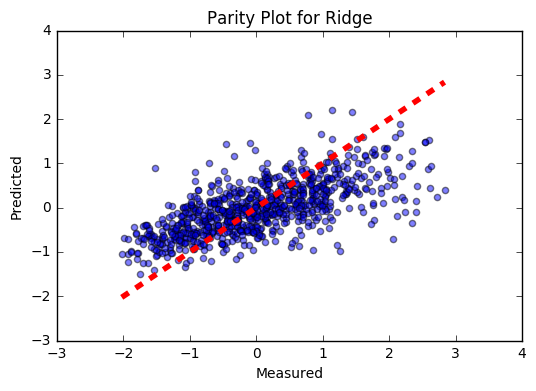

In [39]:
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_CV, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Ridge')
plt.show()

In [40]:
regr_kr=KernelRidge(alpha=1.0)
model_kr=regr_kr.fit(x_training_set, y_training_set)
y_predict_kr=model_kr.predict(x_test_set)
#scale back to original space
#y_predict_kr_true=y_scaler.inverse_transform(y_predict_kr)
#evaluate
mse_kr=mean_squared_error(y_test_set, y_predict_kr)
rmse_kr=sqrt(mse_kr)
mae_kr=mean_absolute_error(y_test_set, y_predict_kr)
r2_kr=r2_score(y_test_set, y_predict_kr)
print('r2 for kernel ridge in true space:',r2_kr)
print('rmse for kernel ridge in true space:', rmse_kr)
print('mae for kernel ridge in true space:', mae_kr)

r2 for kernel ridge in true space: 0.440137117632
rmse for kernel ridge in true space: 0.7475786424563788
mae for kernel ridge in true space: 0.587543621058


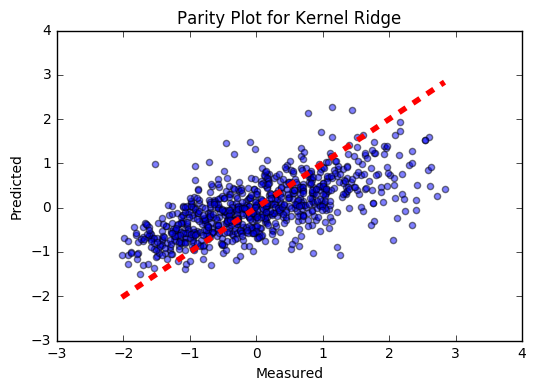

In [41]:
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_kr, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for Kernel Ridge')
plt.show()

In [42]:
#support vector machines
svr_rbf=SVR(kernel='rbf', C=1e3)
model_rbf=svr_rbf.fit(x_training_set, y_training_set)
y_predict_rbf=model_rbf.predict(x_test_set)
#scale back to original space
#y_predict_rbf_true=y_scaler.inverse_transform(y_predict_rbf)
#evaluate
mse_rbf=mean_squared_error(y_test_set, y_predict_rbf)
rmse_rbf=sqrt(mse_rbf)
mae_rbf=mean_absolute_error(y_test_set, y_predict_rbf)
r2_rbf=r2_score(y_test_set, y_predict_rbf)
print('r2 for svm.rbf in true space:',r2_rbf)
print('rmse for svm.rbf in true space:', rmse_rbf)
print('mae for svm.rbf in true space:', mae_rbf)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 for svm.rbf in true space: 0.459311738261
rmse for svm.rbf in true space: 0.7346652843166859
mae for svm.rbf in true space: 0.566559193489


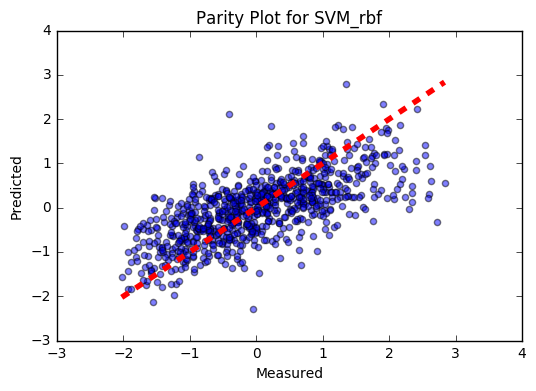

In [43]:
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_rbf, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for SVM_rbf')
plt.show()

In [44]:
svr_sig=SVR(kernel='sigmoid', C=1e3)
model_sig=svr_sig.fit(x_training_set, y_training_set)
y_predict_sig=model_sig.predict(x_test_set)
#scale back to original space
#y_predict_sig_true=y_scaler.inverse_transform(y_predict_sig)
#evaluate
mse_sig=mean_squared_error(y_test_set, y_predict_sig)
rmse_sig=sqrt(mse_sig)
mae_sig=mean_absolute_error(y_test_set, y_predict_sig)
r2_sig=r2_score(y_test_set, y_predict_sig)
print('r2 for svm.sig in true space:',r2_sig)
print('rmse for svm.sig in true space:', rmse_sig)
print('mae for svm.sig in true space:', mae_sig)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 for svm.sig in true space: -51788921436.1
rmse for svm.sig in true space: 227370.69061081103
mae for svm.sig in true space: 183612.095272


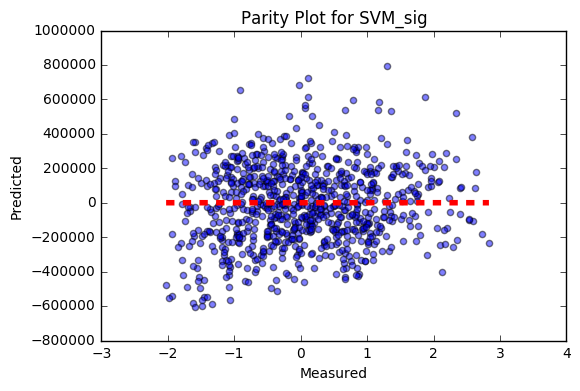

In [45]:
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predict_sig, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'r--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Parity Plot for SVM_sig')
plt.show()

In [70]:
#C=np.array([rmse_linear, rmse_lasso, rmse_lassoCV, rmse_larsCV, rmse_b, rmse_sgd, rmse_sgd2, rmse_sgd3, rmse_tree, rmse_ridge, rmse_kr, rmse_rbf, rmse_rbf])
#C

In [71]:
C=np.array([r2_linear, r2_lasso, r2_lassoCV, r2_larsCV, r2_b, r2_sgd, r2_sgd2, r2_sgd3, r2_tree, r2_ridge, r2_kr, r2_rbf])
C

array([ 0.43960348,  0.43797658,  0.43871472,  0.43804081,  0.43859648,
        0.42044982,  0.43143189,  0.37633677, -0.06706485,  0.43959926,
        0.44013712,  0.45931174])

In [72]:
D=np.array(np.arange(1, 13.0, 1))
D

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.])

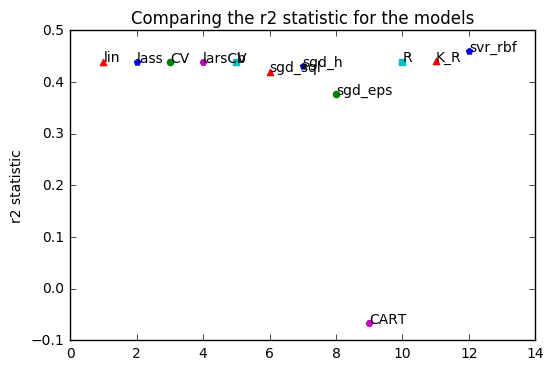

In [73]:
plt.scatter(D[0],C[0], color='r',marker='^', alpha=1)
plt.scatter(D[1],C[1], color='b',marker='p', alpha=1)
plt.scatter(D[2],C[2], color='g',marker='o', alpha=1)
plt.scatter(D[3],C[3], color='m',marker='H', alpha=1)
plt.scatter(D[4],C[4], color='c',marker='s', alpha=1)
plt.scatter(D[5],C[5], color='r',marker='^', alpha=1)
plt.scatter(D[6],C[6], color='b',marker='p', alpha=1)
plt.scatter(D[7],C[7], color='g',marker='o', alpha=1)
plt.scatter(D[8],C[8], color='m',marker='H', alpha=1)
plt.scatter(D[9],C[9], color='c',marker='s', alpha=1)
plt.scatter(D[10],C[10], color='r',marker='^', alpha=1)
plt.scatter(D[11],C[11], color='b',marker='p', alpha=1)
#plt.scatter(D[12],C[12], color='g',marker='o', alpha=1)
#plt.scatter(D[13],C[13], color='m',marker='H', alpha=1)
#plt.scatter(D[14],C[14], color='m',marker='H', alpha=1)
n=['lin','lass','CV','larsCV','b','sgd_sql','sgd_h','sgd_eps','CART','R','K_R','svr_rbf']
for i, txt in enumerate(n):
    plt.annotate(txt, (D[i],C[i]))

plt.ylabel('r2 statistic')
plt.title('Comparing the r2 statistic for the models')
plt.show()

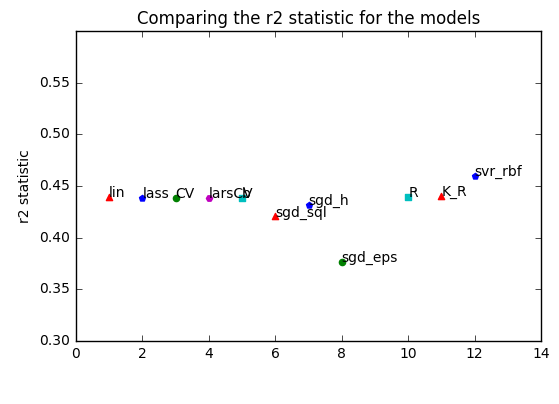

In [74]:
plt.scatter(D[0],C[0], color='r',marker='^', alpha=1)
plt.scatter(D[1],C[1], color='b',marker='p', alpha=1)
plt.scatter(D[2],C[2], color='g',marker='o', alpha=1)
plt.scatter(D[3],C[3], color='m',marker='H', alpha=1)
plt.scatter(D[4],C[4], color='c',marker='s', alpha=1)
plt.scatter(D[5],C[5], color='r',marker='^', alpha=1)
plt.scatter(D[6],C[6], color='b',marker='p', alpha=1)
plt.scatter(D[7],C[7], color='g',marker='o', alpha=1)
plt.scatter(D[8],C[8], color='m',marker='H', alpha=1)
plt.scatter(D[9],C[9], color='c',marker='s', alpha=1)
plt.scatter(D[10],C[10], color='r',marker='^', alpha=1)
plt.scatter(D[11],C[11], color='b',marker='p', alpha=1)
#plt.scatter(D[12],C[12], color='g',marker='o', alpha=1)
#plt.scatter(D[13],C[13], color='m',marker='H', alpha=1)
#plt.scatter(D[14],C[14], color='m',marker='H', alpha=1)
n=['lin','lass','CV','larsCV','b','sgd_sql','sgd_h','sgd_eps','CART','R','K_R','svr_rbf']
for i, txt in enumerate(n):
    plt.annotate(txt, (D[i],C[i]))

plt.ylabel('r2 statistic')
plt.ylim([0.30, 0.6])
plt.title('Comparing the r2 statistic for the models')
plt.show()

In [75]:
C=np.array([rmse_linear, rmse_lasso, rmse_lassoCV, rmse_larsCV, rmse_b, rmse_sgd, rmse_sgd2, rmse_sgd3, rmse_tree, rmse_ridge, rmse_kr, rmse_rbf])
C

array([ 0.74793484,  0.74901973,  0.7485277 ,  0.74897692,  0.74860653,
        0.76060919,  0.75336822,  0.78902564,  1.03207547,  0.74793765,
        0.74757864,  0.73466528])

In [76]:
D=np.array(np.arange(1, 13.0, 1))
D

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.])

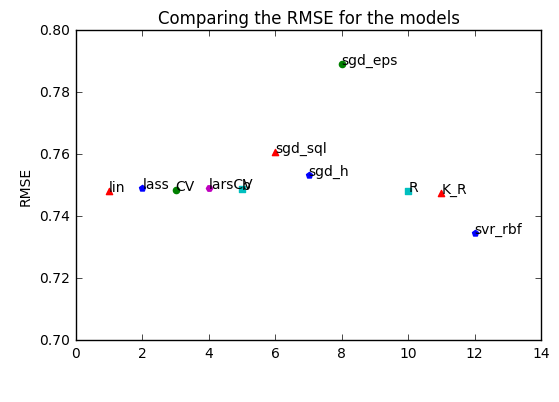

In [78]:
plt.scatter(D[0],C[0], color='r',marker='^', alpha=1)
plt.scatter(D[1],C[1], color='b',marker='p', alpha=1)
plt.scatter(D[2],C[2], color='g',marker='o', alpha=1)
plt.scatter(D[3],C[3], color='m',marker='H', alpha=1)
plt.scatter(D[4],C[4], color='c',marker='s', alpha=1)
plt.scatter(D[5],C[5], color='r',marker='^', alpha=1)
plt.scatter(D[6],C[6], color='b',marker='p', alpha=1)
plt.scatter(D[7],C[7], color='g',marker='o', alpha=1)
plt.scatter(D[8],C[8], color='m',marker='H', alpha=1)
plt.scatter(D[9],C[9], color='c',marker='s', alpha=1)
plt.scatter(D[10],C[10], color='r',marker='^', alpha=1)
plt.scatter(D[11],C[11], color='b',marker='p', alpha=1)
#plt.scatter(D[12],C[12], color='g',marker='o', alpha=1)
#plt.scatter(D[13],C[13], color='m',marker='H', alpha=1)
#plt.scatter(D[14],C[14], color='m',marker='H', alpha=1)
n=['lin','lass','CV','larsCV','b','sgd_sql','sgd_h','sgd_eps','CART','R','K_R','svr_rbf']
for i, txt in enumerate(n):
    plt.annotate(txt, (D[i],C[i]))

plt.ylabel('RMSE')
plt.ylim([0.70, 0.80])
plt.title('Comparing the RMSE for the models')
plt.show()

In [80]:
C=np.array([mae_linear, mae_lasso, mae_lassoCV, mae_larsCV, mae_b, mae_sgd, mae_sgd2, mae_sgd3, mae_tree, mae_ridge, mae_kr, mae_rbf])
C

array([ 0.58742821,  0.59079139,  0.58964389,  0.59049275,  0.58877305,
        0.59194496,  0.58303211,  0.60812342,  0.80068209,  0.58743428,
        0.58754362,  0.56655919])

In [81]:
D=np.array(np.arange(1, 13.0, 1))
D

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.])

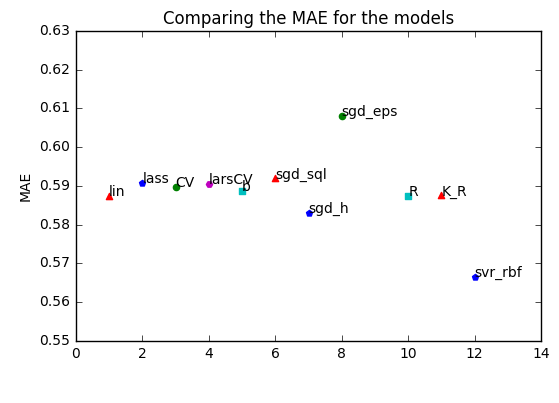

In [82]:
plt.scatter(D[0],C[0], color='r',marker='^', alpha=1)
plt.scatter(D[1],C[1], color='b',marker='p', alpha=1)
plt.scatter(D[2],C[2], color='g',marker='o', alpha=1)
plt.scatter(D[3],C[3], color='m',marker='H', alpha=1)
plt.scatter(D[4],C[4], color='c',marker='s', alpha=1)
plt.scatter(D[5],C[5], color='r',marker='^', alpha=1)
plt.scatter(D[6],C[6], color='b',marker='p', alpha=1)
plt.scatter(D[7],C[7], color='g',marker='o', alpha=1)
plt.scatter(D[8],C[8], color='m',marker='H', alpha=1)
plt.scatter(D[9],C[9], color='c',marker='s', alpha=1)
plt.scatter(D[10],C[10], color='r',marker='^', alpha=1)
plt.scatter(D[11],C[11], color='b',marker='p', alpha=1)
#plt.scatter(D[12],C[12], color='g',marker='o', alpha=1)
#plt.scatter(D[13],C[13], color='m',marker='H', alpha=1)
#plt.scatter(D[14],C[14], color='m',marker='H', alpha=1)
n=['lin','lass','CV','larsCV','b','sgd_sql','sgd_h','sgd_eps','CART','R','K_R','svr_rbf']
for i, txt in enumerate(n):
    plt.annotate(txt, (D[i],C[i]))

plt.ylabel('MAE')
plt.ylim([0.55, 0.63])
plt.title('Comparing the MAE for the models')
plt.show()

**NEURAL NETWORK**

In [83]:
#DIFFERENT TOPOLOGIES HAVE BEEN GIVEN TO 2D , 3D AND 2D/3D DESCRIPTORS AND ITERATIONS OF CONJUGATED GRADIENT DESCENT GIVEN
def baseline_model():
    model=Sequential()
    model.add(Dropout(0.2, input_shape=(30,)))
    model.add(Dense(30, init='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(24, init='normal', activation='relu'))
    model.add(Dense(12, init='normal', activation='relu'))
    model.add(Dense(6, init='normal', activation='relu'))
    model.add(Dense(3, init='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, init='normal'))
    # compile the model 
    epochs=100
    learning_rate=0.01
    momemtum=0.3
    decay=learning_rate/epochs
    sgd=SGD(lr=learning_rate, momentum=momemtum, decay=decay, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [84]:
seed=7
#fit and evaluate the NN#USE OF STRATIFIEDKFOLD ONLY FOR BINARY CLASSIFICATION
estimators=[]
#estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)))
pipeline=Pipeline(estimators)
kfold=KFold(n_splits=10, shuffle=True, random_state=seed)
results=cross_val_score(pipeline, x_training_set, y_training_set, cv=kfold, scoring='r2')
results.mean(), results.std()

C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(30, kernel_initializer="normal", activation="relu")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(24, kernel_initializer="normal", activation="relu")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, kernel_initializer="normal", activation="relu")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, kernel_initializer="normal", activation="relu")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_initializer="normal", activation="relu")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:

(0.3084467117973359, 0.15818744820861569)

In [ ]:
results_test=cross_val_score(pipeline, x_test_set, y_test_set, cv=kfold, scoring='r2')
results_test.mean(), results_test.std()

**TENSORFLOW MODEL**

In [ ]:
import tensorflow as tf

In [ ]:
COLUMNS=list(x_df)
len(COLUMNS)